# Hyperparameter Tuning on Vision Transformer (ViT)
Dataset: [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) \
Huggingface Models: [WinKawaks/vit-tiny-patch16-224](https://huggingface.co/WinKawaks/vit-tiny-patch16-224)

\
Inference Metrices on Default ViT:
  - Accuracy Score,
  - F1 Score,
  - Confusion Metrix,
  - Log Loss (Cross-Entropy Loss),
  - Top-K Accuracy Score.

In [1]:
!pip install transformers
!pip install deap
!pip install hf_xet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 109.6 MB/s eta 0:00:00


In [2]:
# Import modules
from sklearn.metrics import accuracy_score, f1_score, log_loss, confusion_matrix, top_k_accuracy_score
from transformers import ViTConfig, ViTForImageClassification
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import CIFAR100
from torchvision import transforms
from scipy.special import softmax
import matplotlib.pyplot as plt
import torch.optim as optim
from torch import nn, optim
from torch.optim import AdamW
import seaborn as sns
from time import time
import pandas as pd
import numpy as np
import torch
from zipfile import ZipFile
from google.colab import files
import random, csv, os, gc, shutil
from deap import base, creator, tools, algorithms

# Phase 1: Dataset Preparation
In this first section, we will create training and testing subsets of the ***CIFAR-100*** dataste, making sure to ***transform*** them to the right compatable deminsions for ingeting into the ViT model to *train/validation/inference*.
### Tasks:
1. Create a Data Transformation Property:
  - ***Image Resize:*** *32x32 ---> 224x224*,
  - ***Data Augmentations:*** *Random Horizontal Flips, Random Rotations (of 10°)*.
2. Clear Dataset Cache (if exists),
3. Download CIFAR-100 Dataset and Create Subsets:
  - Pass the ***Transformation Property*** as Transform Argument,
  - Save Dataset Subsets to ***'./data'*** folder
  - Create ***Train Subset:*** *1000 images, train=True*
  - Create ***Test Subset:*** *1000 images, train=False*
4. Create Dataloaders:
- **Number of Worksers:** *2 (for more data efficiency)*,
- **Training Dataloader:** *Shuffle=True*,
- **Testing Dataloader:** *Shuffle=False*,
5. Show Random Instances of each Subsets
6. Create Evulation Functions

In [3]:
# Data Transformation (resize to 224x224 for ViT)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),  # Random Augmentation enabled during training
    transforms.RandomRotation(10),      # Random Augmentation (rotations) enabled during training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

In [4]:
# Clear any potential cache
!rm -rf ./data/cifar-100-python*

# Load CIFAR-100 dataset properly (Ensuring separate train and test sets)
# Train dataset (fine-tuning subset)
train_dataset = CIFAR100(root="./data", train=True, download=True, transform=transform)

# Test dataset (separate from train set to avoid data leakage)
test_dataset = CIFAR100(root="./data", train=False, download=True, transform=transform)

# Creating training subset (random 20,000 images for training)
train_subset = Subset(train_dataset, torch.randperm(len(train_dataset))[:20000])
train_subset.classes = train_dataset.classes

# Creating test subset (random 1,000 images for inference/testing)
test_subset = Subset(test_dataset, torch.randperm(len(test_dataset))[:2000])
test_subset.classes = test_dataset.classes

print(f"Train Subset: {len(train_subset)} images")
print(f"Test Subset: {len(test_subset)} images")

100%|██████████| 169M/169M [00:12<00:00, 13.3MB/s]


Train Subset: 20000 images
Test Subset: 2000 images


In [5]:
# DataLoaders (with 2 workers for data efficiency)
train_loader = DataLoader(train_subset, batch_size=16, shuffle=True, num_workers=2) # shuffle=True, for training
test_loader = DataLoader(test_subset, batch_size=16, shuffle=False, num_workers=2) # shuffle=False, for testing

print(f"Test_loader Batch-size: {test_loader.batch_size}")
print(f"Train_loader Batch-size: {train_loader.batch_size}")

Test_loader Batch-size: 16
Train_loader Batch-size: 16




Training Subset:


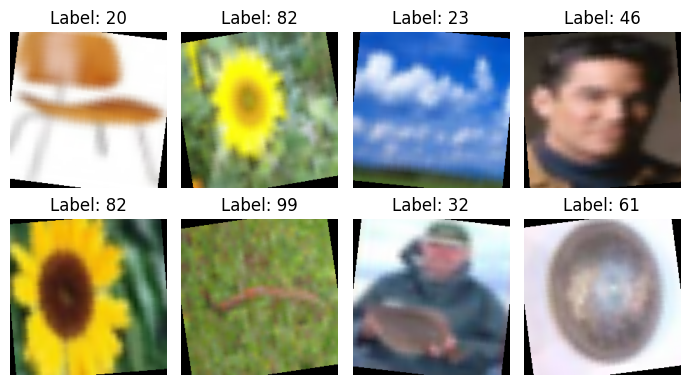



Testing Subset:


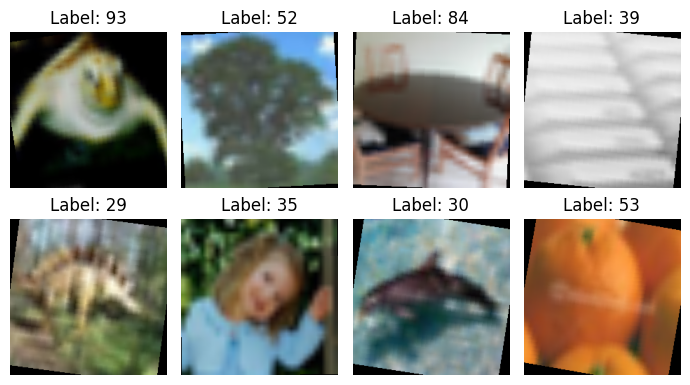

In [6]:
# Showing Data
random_train_indices = torch.randperm(len(train_subset))[:8]    # Get 8 random indices from training subset
random_test_indices = torch.randperm(len(train_subset))[:8]     # Get 8 random indices from testing subset

def show_images(indices, txt):
  fig, axes = plt.subplots(2, 4, figsize=(7, 4))               # Create a figure and axes for the grid
  axes = axes.flatten()                                         # Flatten axes for easy iteration
  for i, idx in enumerate(indices):                             # Iterate through the random indices and plot images
      image, label = train_subset[idx]
      image = image.permute(1, 2, 0)                            # Transpose the image tensor to have the correct dimensions for plotting (HWC instead of CHW)
      mean = torch.tensor([0.5, 0.5, 0.5])                      # unnormalize the pixel values
      std = torch.tensor([0.5, 0.5, 0.5])
      mean = mean.reshape(1, 1, -1)                             # Reshape mean and std to be compatible with image tensor
      std = std.reshape(1, 1, -1)
      image = std * image + mean
      image = torch.clip(image, 0, 1)
      image = image.numpy()
      axes[i].imshow(image)
      axes[i].set_title(f"Label: {label}")
      axes[i].axis('off')                                       # Turn off axes for cleaner view

  print(f"\n\n{txt}")
  plt.tight_layout()
  plt.show()

show_images(random_train_indices, "Training Subset:")
show_images(random_test_indices, "Testing Subset:")

In [7]:
# Inference evulation function
def evaluate_model(model, dataloader, dataset):
  model.eval()
  # start_time = time()
  all_preds, all_labels, all_logits = [], [], []
  with torch.no_grad():
      for batch in dataloader:
          inputs = batch[0].to(device)
          labels = batch[1].to(device)
          outputs = model(inputs)
          logits = outputs.logits
          preds = torch.argmax(logits, dim=1)
          probs = torch.nn.functional.softmax(logits, dim=1)           # Convert logits to probabilities
          all_preds.extend(preds.cpu().numpy())
          all_labels.extend(labels.cpu().numpy())
          all_logits.extend(logits.cpu().numpy())

  # Calculate log loss
  probabilities = softmax(np.array(all_logits), axis=1)

  return {
      "Accuracy": round(accuracy_score(all_labels, all_preds), 6),                   # accuracy
      "F1-Score": round(f1_score(all_labels, all_preds, average='macro'), 6),         # F1 scores
      "Top-2 Acc.": round(top_k_accuracy_score(all_labels, probabilities, k=2), 4),   # top-K accuracies
      "Top-5 Acc.": round(top_k_accuracy_score(all_labels, probabilities, k=5), 4),   # top-K accuracies
      "Log Loss": round(log_loss(all_labels, probabilities), 6),
      "all_labels": all_labels,
      "all_preds": all_preds,
      "classes": dataset.classes,
      "Dataset Length": len(dataset)
      }

In [8]:
def print_metrics(metrics):
  if "profile" in metrics:
    print(f"Profile: {metrics['Profile']}")
  print(f"Accuracy Score: {metrics['Accuracy']:.6f} ({metrics['Accuracy'] * 100:.2f}%)")
  print(f"F1-Score: {metrics['F1-Score']:.6f} ({metrics['F1-Score'] * 100:.2f}%)")
  print(f"Top-2 Accuracy: {metrics['Top-2 Acc.'] * 100:.2f}%")
  print(f"Top-5 Accuracy: {metrics['Top-5 Acc.'] * 100:.2f}%")
  print(f"Log Loss: {metrics['Log Loss']:.6f}")
  if "Peak Training Memory (MB)" in metrics:
    print(f"Peak Training Memory (MB): {metrics['Peak Training Memory (MB)']:.2f}")
  if "Training Time (s)" in metrics:
    print(f"Training Time (s): {metrics['Training Time (s)']:.4f}")
  if "Peak Inference Memory (MB)" in metrics:
    print(f"Peak Inference Memory (MB): {metrics['Peak Inference Memory (MB)']:.2f}")
  if "Inference Time (s)" in metrics:
    print(f"Inference Time (s): {metrics['Inference Time (s)']:.4f} ({round(metrics['Inference Time (s)'] / metrics['Dataset Length'], 6)}/image)\n")

In [9]:
# Function to plot Confusion Matrix (for evulation)
def plot_confusion_matrix(true_Values, pred_Values, class_Names, Title):
  cm = confusion_matrix(true_Values, pred_Values)
  plt.figure(figsize=(16, 12))
  sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_Names, yticklabels=class_Names)
  plt.xlabel("Predicted")
  plt.ylabel("True")
  plt.title(Title)
  plt.show()

# Phase 2: Inference on Default ViT Model
In this section, we will load the default ViT model, to the accuracy metrices on the Default ViT.

### Tasks:
1. Load Default ViT Model: *WinKawaks/vit-tiny-patch16-224*,
  - ***Update Classifier Head:*** *1000 ---> 100*,
  - Reinitialize Classifier Weights upon Modification.
2. Move the Model to GPU (if GPU is available),
3. Run Inference Loop: Get Accuracy Score.
4. Plot Confusion Matrix Heatamap.

In [10]:
# Load the Default vit-tiny-patch16-224 (TinyVit) models and configs
default_model = ViTForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")

# Fix CIFAR-100 classifiers for 100 classes (from 1000 classes)
default_model.classifier = torch.nn.Linear(default_model.config.hidden_size, 100)
default_model_config = default_model.config

# Reinitialize classifier weights after modification, using Xavier Uniform initialization
torch.nn.init.xavier_uniform_(default_model.classifier.weight)
print(f"Classifier weights reinitialized:")
print("Default ViT Model:", default_model.classifier)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

Classifier weights reinitialized:
Default ViT Model: Linear(in_features=192, out_features=100, bias=True)


In [11]:
# Move Default ViT Model to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
default_model.to(device)

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=192, out_features=768, bias=True)
            (intermedi

In [58]:
# Inference on Default ViT
torch.cuda.reset_peak_memory_stats(device)  # reset GPU memory (to track)
t_start = time()                            # track time start
eval_default = evaluate_model(default_model, test_loader, test_dataset)   # main inference
inf_time_sec = time() - t_start             # track time end
peak_inf_mb = torch.cuda.max_memory_allocated(device) / (1024**2)   # track GPU memory

# Adding timing and GPU usage of inference
eval_default["Inference Time (s)"] = round(inf_time_sec, 4)
eval_default["Inference per Image (s)"] = round(inf_time_sec / eval_default["Dataset Length"], 6)
eval_default["Peak Inference Memory (MB)"] = round(peak_inf_mb, 4)

# Delete unecessary values, while saving their them saperately (for confusion matrix)
all_labels = eval_default["all_labels"]
all_preds = eval_default["all_preds"]
classes = eval_default["classes"]
del eval_default["all_labels"]; del eval_default["all_preds"]; del eval_default["classes"]

# Printing the metrices
print(f"Default ViT Model:")
print('='*18)
print_metrics(eval_default)

Default ViT Model:
Accuracy Score: 0.005000 (0.50%)
F1-Score: 0.003530 (0.35%)
Top-2 Accuracy: 1.25%
Top-5 Accuracy: 4.65%
Log Loss: 10.837173
Peak Inference Memory (MB): 338.33
Inference Time (s): 2.2429 (0.000224/image)



In [47]:
# Save to Excel
with pd.ExcelWriter("all_experiments.xlsx", engine="openpyxl") as writer:
  df_default = pd.DataFrame(eval_default, index=[0])
  df_default.to_excel(writer, sheet_name="Default Model", index=False)

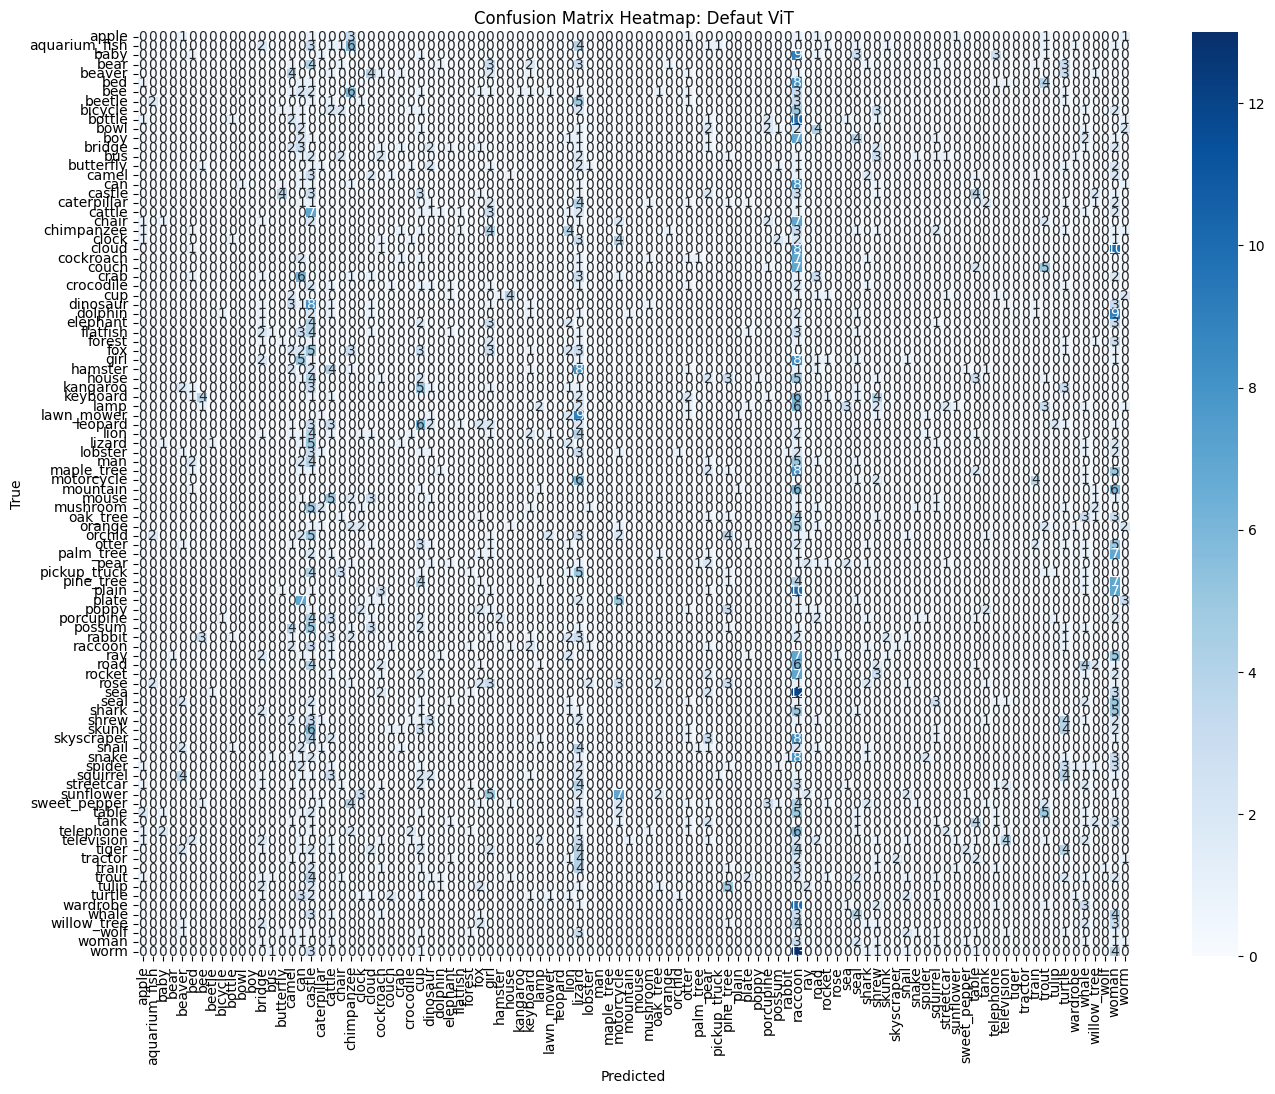

In [14]:
plot_confusion_matrix(all_labels, all_preds, classes, "Confusion Matrix Heatmap: Defaut ViT")

# Phase 3: Inference on Manually Fine-tuned ViT Model
In this section, we will load the ViT model, and manually fine-tune, and then record its accuracy metrices for inference.

### Tasks:
1. Load Default ViT Model: *WinKawaks/vit-tiny-patch16-224*,
  - ***Update Classifier Head:*** *1000 ---> 100*,
  - Reinitialize Classifier Weights upon Modification.
2. Move the Model to GPU (if GPU is available),
3. Manually define 1 or 2 training hyperparameters,
4. Train (fine-tune) the model with teh defined hyperparameters,
5. Run Inference Loop: Get Accuracy Score.
6. Plot Confusion Matrix Heatamap.

In [15]:
# Hyperparams to vary: lr, dropout, optimizer, weight_decay
epochs = 5
manual_space = [
    {"lr": 3e-4, "dropout": 0.0, "optimizer": "AdamW", "wd": 0},
    {"lr": 3e-4, "dropout": 0.0, "optimizer": "SGD", "wd": 0},
    {"lr": 1e-4, "dropout": 0.1, "optimizer": "AdamW", "wd": 1e-5},
    {"lr": 1e-4, "dropout": 0.1, "optimizer": "SGD", "wd": 1e-5},
    {"lr": 5e-5, "dropout": 0.2, "optimizer": "AdamW", "wd": 1e-4},
    {"lr": 5e-5, "dropout": 0.2, "optimizer": "SGD", "wd": 1e-4},
    {"lr": 1e-5, "dropout": 0.3, "optimizer": "AdamW", "wd": 1e-5},
    {"lr": 1e-5, "dropout": 0.3, "optimizer": "SGD", "wd": 1e-5},
    {"lr": 5e-4, "dropout": 0.4, "optimizer": "AdamW", "wd": 1e-3},
    {"lr": 5e-4, "dropout": 0.4, "optimizer": "SGD", "wd": 1e-3},
]

In [16]:
# Manual Loop
results = []

for idx, cfg in enumerate(manual_space, start=1):
    print(f"Hyperparams: {cfg}")
    # 1) reload fresh model
    manual_model = ViTForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")
    manual_model.classifier = nn.Linear(manual_model.config.hidden_size, 100)
    nn.init.xavier_uniform_(manual_model.classifier.weight)
    manual_model.config.hidden_dropout_prob = cfg["dropout"]
    manual_model.config.attention_probs_dropout_prob = cfg["dropout"]
    manual_model.to(device)

    # 2) choose optimizer
    if cfg["optimizer"] == "Adam":
        opt = optim.Adam(manual_model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"])
    else:
        # when choosing SGD, declare a default momentum for it (0.9 from default=0)
        opt = optim.SGD(manual_model.parameters(), lr=cfg["lr"], weight_decay=cfg["wd"], momentum=0.9)

    # 3) TRAINING with timing & GPU‐mem tracking
    torch.cuda.reset_peak_memory_stats(device)
    t0 = time()
    # Train for 2 epochs
    for epoch in range(epochs):
        manual_model.train()
        running_loss = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            opt.zero_grad()
            loss = nn.CrossEntropyLoss()(manual_model(images).logits, labels)
            loss.backward()
            opt.step()
            running_loss += loss.item()
        # Print training progress
        avg_loss = running_loss / len(train_loader)

        # Evaluate on the training split to get acc, f1, log_loss
        train_mets = evaluate_model(manual_model, train_loader, train_subset)
        print(
            f"Epoch [{epoch+1}/{epochs}]  - "
            f"Accuracy: {train_mets['Accuracy']:.2f}%  "
            f"F1: {train_mets['F1-Score']:.4f}  "
            f"Loss: {avg_loss:.4f}"
        )

    train_time_sec = time() - t0
    peak_train_mb = torch.cuda.max_memory_allocated(device) / (1024**2)

    # 4) Inference on test subset with timing & GPU‐mem tracking
    torch.cuda.reset_peak_memory_stats(device)
    t1 = time()
    test_mets = evaluate_model(manual_model, test_loader, test_subset)
    inf_time_sec = time() - t1
    peak_inf_mb = torch.cuda.max_memory_allocated(device) / (1024**2)

    test_mets["Training Time (s)"] = round(train_time_sec, 4)
    test_mets["Peak Training Memory (MB)"] = round(peak_train_mb, 4)
    test_mets["Inference Time (s)"] = round(inf_time_sec, 4)
    test_mets["Peak Inference Memory (MB)"] = round(peak_inf_mb, 4)
    test_mets["Inference per Image (s)"] = round(inf_time_sec / test_mets["Dataset Length"], 6)

    # 5) Print inference metrics
    print('='*60)
    print_metrics(test_mets)

    # 6) merge hyperparams + metrics
    row = {
        "Profile":      idx,
        "Learning Rate": cfg["lr"],
        "Dropout":      cfg["dropout"],
        "Optimizer":    cfg["optimizer"],
        "Weight Decay": cfg["wd"],
        "Accuracy":     test_mets["Accuracy"],
        "F1-Score":     test_mets["F1-Score"],
        "Top-2 Acc.":     test_mets["Top-2 Acc."],
        "Top-5 Acc.":     test_mets["Top-5 Acc."],
        "Log Loss":     test_mets["Log Loss"],
        "Peak Training Memory (MB)": test_mets["Peak Training Memory (MB)"],
        "Training Time (s)": test_mets["Training Time (s)"],
        "Peak Inference Memory (MB)": test_mets["Peak Inference Memory (MB)"],
        "Inference Time (s)": test_mets["Inference per Image (s)"],
        "Inference per Image (s)": test_mets["Inference per Image (s)"]
    }
    results.append(row)

Hyperparams: {'lr': 0.0003, 'dropout': 0.0, 'optimizer': 'AdamW', 'wd': 0}
Epoch [1/5]  - Accuracy: 0.57%  F1: 0.5604  Loss: 3.1459
Epoch [2/5]  - Accuracy: 0.76%  F1: 0.7505  Loss: 1.2829
Epoch [3/5]  - Accuracy: 0.83%  F1: 0.8264  Loss: 0.8264
Epoch [4/5]  - Accuracy: 0.88%  F1: 0.8829  Loss: 0.5833
Epoch [5/5]  - Accuracy: 0.91%  F1: 0.9093  Loss: 0.4154
Accuracy Score: 0.737000 (73.70%)
F1-Score: 0.731724 (73.17%)
Top-2 Accuracy: 85.20%
Top-5 Accuracy: 93.95%
Log Loss: 0.983205
Peak Training Memory (MB): 559.73
Training Time (s): 321.2388
Peak Inference Memory (MB): 149.73
Inference Time (s): 2.2627 (0.001131/image)

Hyperparams: {'lr': 0.0003, 'dropout': 0.0, 'optimizer': 'SGD', 'wd': 0}
Epoch [1/5]  - Accuracy: 0.53%  F1: 0.5267  Loss: 3.1583
Epoch [2/5]  - Accuracy: 0.74%  F1: 0.7370  Loss: 1.4082
Epoch [3/5]  - Accuracy: 0.80%  F1: 0.8008  Loss: 0.9006
Epoch [4/5]  - Accuracy: 0.87%  F1: 0.8686  Loss: 0.6419
Epoch [5/5]  - Accuracy: 0.90%  F1: 0.8957  Loss: 0.4563
Accuracy Scor

In [48]:
# Build DataFrame
df_manual = pd.DataFrame(results)

# Find the maximum accuracy
max_acc = df_manual["Accuracy"].max()

# Create the best_model flag
df_manual["Best Model"] = df_manual["Accuracy"] == max_acc

# Reorder columns so best_model appears earlier
cols = [
    "Profile", "Best Model", "Learning Rate", "Dropout", "Optimizer", "Weight Decay",
    "Accuracy", "F1-Score", "Top-2 Acc.", "Top-5 Acc.", "Log Loss",
    "Training Time (s)", "Peak Training Memory (MB)",
    "Inference Time (s)", "Inference per Image (s)", "Peak Inference Memory (MB)"
]
df_manual = df_manual[cols]

# Save to Excel
with pd.ExcelWriter("all_experiments.xlsx", engine="openpyxl", mode="a") as writer:
    df_manual.to_excel(writer, sheet_name="Manual Profiles", index=False)

In [18]:
# Find the best profile in df_manual
best_row = df_manual[df_manual["Best Model"]].iloc[0]
val_acc = best_row['Accuracy']

# Print best solution
print(f"Best Manual Profile:\n{'='*20}")
print(f"Learning Rate: {best_row['Learning Rate']:.2e}")
print(f"Dropout: {best_row['Dropout']:.2f}")
print(f"Optimizer: {best_row['Optimizer']}")
print(f"Weight Decay: {best_row['Weight Decay']:.2e}")
print(f"Accuracy: {val_acc} ({val_acc*100:.2f}%)")

Best Manual Profile:
Learning Rate: 3.00e-04
Dropout: 0.00
Optimizer: AdamW
Weight Decay: 0.00e+00
Accuracy: 0.737 (73.70%)


In [19]:
# Retrain new model with best found hyperparameter profile
best_manual_retrained = ViTForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")
best_manual_retrained.classifier = nn.Linear(best_manual_retrained.config.hidden_size, 100)
nn.init.xavier_uniform_(best_manual_retrained.classifier.weight)

# Apply dropout
best_manual_retrained.config.hidden_dropout_prob = best_row["Dropout"]
best_manual_retrained.config.attention_probs_dropout_prob = best_row["Dropout"]
best_manual_retrained.to(device)
# Choose optimizer
if best_row["Optimizer"].lower().startswith("adam"):
    opt = AdamW(best_manual_retrained.parameters(), lr=best_row['Learning Rate'], weight_decay=best_row['Weight Decay'])
else:
    opt = optim.SGD(best_manual_retrained.parameters(), lr=best_row['Learning Rate'], weight_decay=best_row['Weight Decay'], momentum=0.9)

# Train for same number of epochs
best_manual_retrained.train()
for epoch in range(epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        opt.zero_grad()
        loss = nn.CrossEntropyLoss()(
            best_manual_retrained(images).logits, labels
        )
        loss.backward()
        opt.step()

print(f"Finished Retraining Best Manual Profile:\n{'='*40}")
print_metrics(evaluate_model(best_manual_retrained, test_loader, test_subset))

Finished Retraining Best Manual Profile:
Accuracy Score: 0.625500 (62.55%)
F1-Score: 0.621997 (62.20%)
Top-2 Accuracy: 75.55%
Top-5 Accuracy: 88.25%
Log Loss: 1.397310


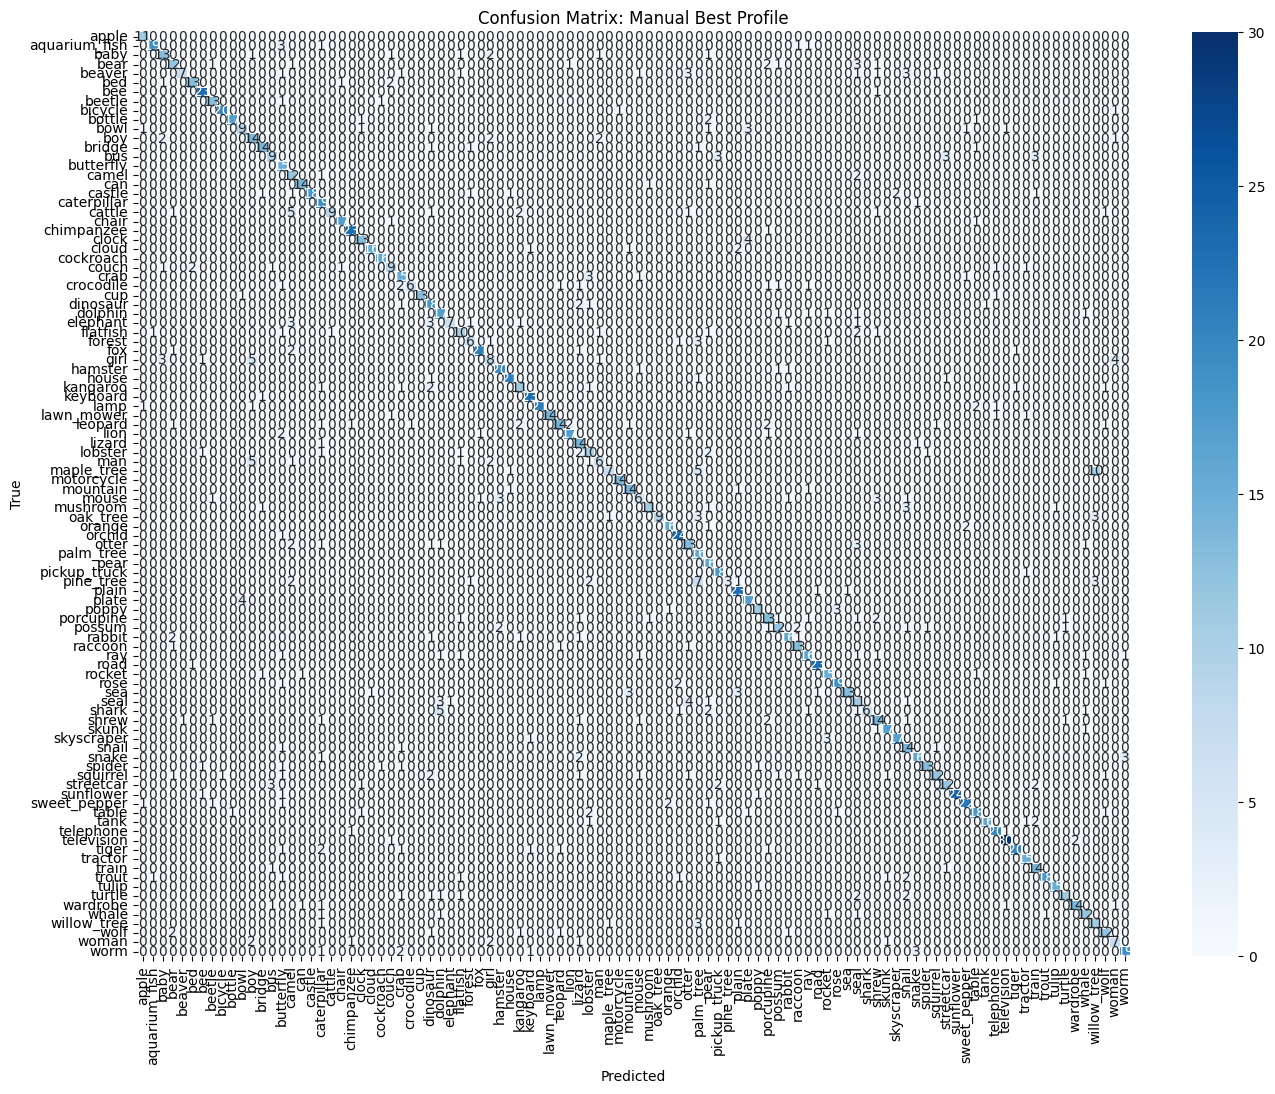

In [20]:
# Plot Confusion Matrix of retrained best model
plot_confusion_matrix(test_mets["all_labels"], test_mets["all_preds"], test_mets["classes"], "Confusion Matrix: Manual Best Profile")

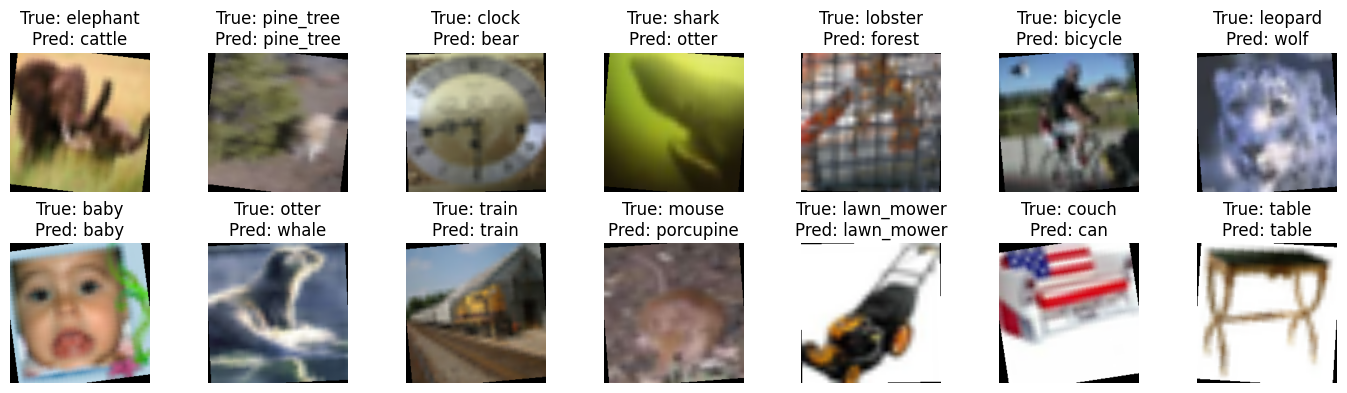

In [21]:
# Display a 2×7 grid of random test images with preds
rows, cols = 2, 7
n_show = rows * cols
indices = random.sample(range(len(test_subset)), n_show)

fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
axes = axes.flatten()

for ax, idx in zip(axes, indices):
    img, true_label = test_subset[idx]
    inp = img.unsqueeze(0).to(device)
    with torch.no_grad():
        pred = best_manual_retrained(inp).logits.argmax(dim=1).item()

    # Un-normalize
    mean = torch.tensor([0.5,0.5,0.5]).reshape(1,1,3)
    std  = torch.tensor([0.5,0.5,0.5]).reshape(1,1,3)
    image = std * img.permute(1,2,0) + mean
    image = image.clamp(0,1).cpu().numpy()

    ax.imshow(image)
    ax.set_title(f"True: {test_subset.classes[true_label]}\nPred: {test_subset.classes[pred]}")
    ax.axis("off")

plt.tight_layout()
plt.show()

# GA Implementation

In [22]:
# Set global seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

"""### Step 0: Define Loss Function"""
# Add this critical missing component
criterion = nn.CrossEntropyLoss()

# Step 1: Define Hyperparameter Search Space
HYPERPARAM_SPACE = {
    'lr': (1e-5, 1e-3),          # Log-uniform distribution
    'dropout': (0.1, 0.5),        # Uniform distribution
    'optimizer': ['AdamW', 'SGD'], # Categorical
    'weight_decay': (1e-6, 1e-3)  # Log-uniform
}

In [23]:
# Step 2: GA Framework Setup
# Create fitness maximization class
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", dict, fitness=creator.FitnessMax)

def create_individual():
    """Generate individual with random hyperparameters"""
    individual = {
        'lr': 10**np.random.uniform(
            np.log10(HYPERPARAM_SPACE['lr'][0]),
            np.log10(HYPERPARAM_SPACE['lr'][1])
        ),
        'dropout': np.random.uniform(*HYPERPARAM_SPACE['dropout']),
        'optimizer': random.choice(HYPERPARAM_SPACE['optimizer']),
        'weight_decay': 10**np.random.uniform(
            np.log10(HYPERPARAM_SPACE['weight_decay'][0]),
            np.log10(HYPERPARAM_SPACE['weight_decay'][1])
        )
    }
    return creator.Individual(individual)

toolbox = base.Toolbox()
toolbox.register("individual", create_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

In [24]:
# Step 3: Fixed Fitness Evaluation Function
def evaluate_individual(individual):
    """Train ViT with given hyperparams and return validation accuracy"""
    # Load fresh model instance
    model = ViTForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")
    model.classifier = torch.nn.Linear(model.config.hidden_size, 100)
    torch.nn.init.xavier_uniform_(model.classifier.weight)
    model.to(device)

    # Apply hyperparameters
    model.config.hidden_dropout_prob = individual['dropout']
    model.config.attention_probs_dropout_prob = individual['dropout']

    # Configure optimizer
    if individual['optimizer'] == 'AdamW':
        optimizer = AdamW(model.parameters(), lr=individual['lr'], weight_decay=individual['weight_decay'])
    else:
        optimizer = torch.optim.SGD(model.parameters(), lr=individual['lr'],
                                  weight_decay=individual['weight_decay'], momentum=0.9)
    print(
        "Hyperparams: ("
        f"lr: {individual['lr']:.2e}, "
        f"dropout: {individual['dropout']:.2f}, "
        f"optimizer: '{individual['optimizer']}', "
        f"wd: {individual['weight_decay']:.2e}, "
        f"epochs: {epochs})"
    )
    # 4) Start tracking GPU mem & timing BEFORE training
    torch.cuda.reset_peak_memory_stats(device)
    start_train = time()

    # Fast training (5 epochs)
    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    train_time = time() - start_train
    peak_train_mb  = torch.cuda.max_memory_allocated(device)/(1024**2)

    # 5) INFERENCE with timing & mem tracking
    torch.cuda.reset_peak_memory_stats(device)
    start_inf = time()

    # Get true labels and predictions
    # y_true, y_pred, _, val_loss = evaluate_model(model, test_loader, test_dataset)
    val_mets = evaluate_model(model, test_loader, test_subset) # test_dataset
    inf_time = time() - start_inf
    peak_inf_mb = torch.cuda.max_memory_allocated(device)/(1024**2)

    metrics = val_mets.copy()
    metrics.update({
        "Training Time (s)": train_time,
        "Peak Training Memory (MB)": peak_train_mb,
        "Inference Time (s)": inf_time,
        "Peak Inference Memory (MB)": peak_inf_mb,
        "Inference per Image (s)": inf_time / len(test_subset)
    })

    # Print Metrices
    individual.metrics = metrics
    print_metrics(metrics)

    y_true = val_mets['all_labels']
    y_pred = val_mets['all_preds']
    # accuracy = val_mets["Accuracy"]
    val_loss = val_mets['Log Loss']
    individual.f1_score = val_mets['F1-Score']
    individual.top2_acc = val_mets['Top-2 Acc.']
    individual.top5_acc = val_mets['Top-5 Acc.']

    individual.loss = individual.metrics["Log Loss"]
    accuracy = individual.metrics["Accuracy"]


    # Attach metrics to individual
    # accuracy = accuracy_score(y_true, y_pred)
    # individual.loss = val_loss
    individual.fitness.values = (accuracy,)
    # individual.n_params = n_params
    # individual.model_size_mb = model_size_mb # MB
    individual.train_time_sec = train_time
    individual.peak_train_mb = peak_train_mb # MB
    individual.inf_time_sec = inf_time
    individual.peak_inf_mb = peak_inf_mb # MB

    acc = metrics["Accuracy"]
    individual.fitness.values = (acc,)
    individual.loss = metrics["Log Loss"]

    # Free GPU memory
    del model
    torch.cuda.empty_cache()

    # return (accuracy,)
    return (acc,)

toolbox.register("evaluate", evaluate_individual)

In [25]:
# Step 4: Genetic Operators
# Tournament selection with size 3
toolbox.register("select", tools.selTournament, tournsize=3)

def crossover(ind1, ind2, alpha=0.5):
    """BLX-α crossover in log-space for lr and weight_decay, linear for dropout."""
    # Continuous numeric in log-space
    for key in ['lr', 'weight_decay']:
        # Convert to log10
        log1 = np.log10(ind1[key])
        log2 = np.log10(ind2[key])
        lo, hi = min(log1, log2), max(log1, log2)
        spread = hi - lo

        # Expand by alpha
        new_log1 = random.uniform(lo - alpha*spread, hi + alpha*spread)
        new_log2 = random.uniform(lo - alpha*spread, hi + alpha*spread)

        # Convert back
        ind1[key] = 10**np.clip(new_log1, np.log10(HYPERPARAM_SPACE[key][0]), np.log10(HYPERPARAM_SPACE[key][1]))
        ind2[key] = 10**np.clip(new_log2, np.log10(HYPERPARAM_SPACE[key][0]), np.log10(HYPERPARAM_SPACE[key][1]))

    # Dropout remains linear uniform
    lo, hi = HYPERPARAM_SPACE['dropout']
    min_d, max_d = min(ind1['dropout'], ind2['dropout']), max(ind1['dropout'], ind2['dropout'])
    spread_d = max_d - min_d

    ind1['dropout'] = np.clip(random.uniform(min_d - alpha*spread_d, max_d + alpha*spread_d), lo, hi)
    ind2['dropout'] = np.clip(random.uniform(min_d - alpha*spread_d, max_d + alpha*spread_d), lo, hi)

    # Categorical optimizer swap
    if random.random() < 0.5:
        ind1['optimizer'], ind2['optimizer'] = ind2['optimizer'], ind1['optimizer']

    return ind1, ind2

toolbox.register("mate", crossover)

In [26]:
def mutate(individual, mu=0, sigma=0.25, prob=0.2):
    """Gaussian perturbation on log10(lr) and log10(weight_decay),
       small Gaussian on dropout, and random hop on optimizer."""
    # lr (log-space gaussian)
    if random.random() < prob:
        log_lr = np.log10(individual['lr'])
        new_log_lr = np.clip(random.gauss(log_lr, sigma), np.log10(HYPERPARAM_SPACE['lr'][0]), np.log10(HYPERPARAM_SPACE['lr'][1]))
        individual['lr'] = 10**new_log_lr

    # weight_decay (log-space gaussian)
    if random.random() < prob:
        log_wd = np.log10(individual['weight_decay'])
        new_log_wd = np.clip(random.gauss(log_wd, sigma), np.log10(HYPERPARAM_SPACE['weight_decay'][0]), np.log10(HYPERPARAM_SPACE['weight_decay'][1]))
        individual['weight_decay'] = 10**new_log_wd

    # dropout (linear gaussian)
    if random.random() < prob:
        new_d = individual['dropout'] + random.gauss(0, 0.05)
        individual['dropout'] = float(np.clip(new_d, *HYPERPARAM_SPACE['dropout']))

    # optimizer (categorical hop)
    if random.random() < prob:
        individual['optimizer'] = random.choice(HYPERPARAM_SPACE['optimizer'])

    return (individual,)

toolbox.register("mutate", mutate)

In [27]:
"""### Step 5: Run Evolutionary Optimization"""
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# GA Parameters
POPULATION_SIZE = 10      # Use higher population size if possible (50-100), 10 for now due to limited GPU
GENERATIONS = 20          # 20 Generations
CXPB = 0.2                # Crossover probability (set to less/equal to 20%, 0.2)
MUTPB = 0.3               # Mutation probability (set to less/equal to 30%, 0.3)
REPRODUCTION_RATE = 0.5   # Reproduction probability (around 70%, kept 0.5 to reduce noise)

print(f"Runing Evolution: {GENERATIONS} Gens, {POPULATION_SIZE} Population, {REPRODUCTION_RATE} Reproduction Rate, {CXPB} Crossover Rate, {MUTPB} Mutation Rate")

# Initialize tracking
best_fitness_history = []
avg_fitness_history = []
best_loss_history    = []
avg_loss_history     = []

# To record every individual each generation
ga_candidates = []

# Initialize population
population = toolbox.population(n=POPULATION_SIZE)

# Start evolutionary loop
for gen in range(GENERATIONS):
    print(f"\n=== Generation {gen+1}/{GENERATIONS} ===")

    # Evaluate entire population
    fitnesses = toolbox.map(toolbox.evaluate, population)
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    # Record metrics
    current_fitness = [ind.fitness.values[0] for ind in population]
    best_fitness_history.append(max(current_fitness))
    avg_fitness_history.append(np.mean(current_fitness))

    # Get losses from individuals
    current_losses = [ind.loss for ind in population]
    # best loss corresponds to the individual with best accuracy
    best_loss_history.append(population[int(np.argmax(current_fitness))].loss)
    avg_loss_history.append(np.mean(current_losses))

    # Log every candidate in this generation
    dataset_len = len(test_subset)
    for idx, ind in enumerate(population, start=1):
        m = ind.metrics
        ga_candidates.append({
            "Generation": gen+1,
            "ID": idx,
            "Learning Rate": ind["lr"],
            "Dropout": ind["dropout"],
            "Optimizer": ind["optimizer"],
            "Weight Decay": ind["weight_decay"],
            "Epochs": epochs,
            "Accuracy": m["Accuracy"],
            "F1-Score": m["F1-Score"],
            "Top-2 Acc.": m["Top-2 Acc."],
            "Top-5 Acc.": m["Top-5 Acc."],
            "Log Loss": m["Log Loss"],
            "Training Time (s)": ind.train_time_sec,
            "Peak Training Memory (MB)": ind.peak_train_mb,
            "Inference Time (s)": m["Inference Time (s)"],
            "Inference per Image (s)": m["Inference per Image (s)"],
            "Peak Inference Memory (MB)": m["Peak Inference Memory (MB)"],
        })

    # Sort population by fitness (descending)
    sorted_pop = sorted(population, key=lambda x: x.fitness.values[0], reverse=True)

    # 2) Split into elites (top 50%) and rest (bottom 50%)
    # split = len(sorted_pop) // 2
    split = int(REPRODUCTION_RATE * POPULATION_SIZE)
    elites = sorted_pop[:split]
    rest   = sorted_pop[split:]  # bottom half

    # 3) From 'rest', pick exact fractions
    num_rest = len(rest)            # e.g. 5 if POP=10
    n_xover = max(1, int(CXPB * num_rest))  # 3 of 5
    n_mutation = max(1, int(MUTPB * num_rest))  # 2 of 5

    # 4) Randomly choose which get crossover vs mutation
    xover_candidates    = random.sample(rest, n_xover)
    remaining_candidates = [ind for ind in rest if ind not in xover_candidates]
    mutate_candidates   = random.sample(remaining_candidates, n_mutation)

    # 5) Apply crossover in pairs to the chosen ones
    for i in range(0, len(xover_candidates), 2):
        if i+1 < len(xover_candidates):
            toolbox.mate(xover_candidates[i], xover_candidates[i+1])

    # 6) Apply mutation to the mutation set
    for ind in mutate_candidates:
        toolbox.mutate(ind)

    # 7) Build next gen
    population = elites + rest

    # Cleanup GPU memory
    if gen % 5 == 0:
        torch.cuda.empty_cache()
        gc.collect()

    best = sorted_pop[0]
    print(f"Best this Gen: lr={best['lr']:.2e}, dropout={best['dropout']:.2f}, optimizer={best['optimizer']}, wd={best['weight_decay']:.2e}, Accuracy={best.fitness.values[0]:.6f}")

final_pop = population

Runing Evolution: 20 Gens, 10 Population, 0.5 Reproduction Rate, 0.2 Crossover Rate, 0.3 Mutation Rate

=== Generation 1/20 ===
Hyperparams: (lr: 5.61e-05, dropout: 0.48, optimizer: 'AdamW', wd: 1.57e-04, epochs: 5)
Accuracy Score: 0.735500 (73.55%)
F1-Score: 0.730129 (73.01%)
Top-2 Accuracy: 84.70%
Top-5 Accuracy: 94.00%
Log Loss: 1.042072
Peak Training Memory (MB): 708.49
Training Time (s): 220.9080
Peak Inference Memory (MB): 307.71
Inference Time (s): 2.2395 (0.00112/image)

Hyperparams: (lr: 1.58e-04, dropout: 0.16, optimizer: 'AdamW', wd: 2.94e-06, epochs: 5)
Accuracy Score: 0.704500 (70.45%)
F1-Score: 0.701194 (70.12%)
Top-2 Accuracy: 82.90%
Top-5 Accuracy: 92.65%
Log Loss: 1.116004
Peak Training Memory (MB): 708.64
Training Time (s): 221.1497
Peak Inference Memory (MB): 312.49
Inference Time (s): 2.2349 (0.001117/image)

Hyperparams: (lr: 1.31e-05, dropout: 0.45, optimizer: 'SGD', wd: 6.36e-05, epochs: 5)
Accuracy Score: 0.344500 (34.45%)
F1-Score: 0.328732 (32.87%)
Top-2 Accur

In [63]:
# Step 6: Analyze Results
# Get Pareto front
pareto_front = tools.sortNondominated(final_pop, len(final_pop), first_front_only=True)[0]

# Print best solution
best_ind = tools.selBest(pareto_front, 1)[0]
val_acc = best_ind.fitness.values[0]
print(f"Best GA-Optimized Hyperparameter Candidate:\n{'='*43}")
print(f"Learning Rate: {best_ind['lr']:.2e}")
print(f"Dropout: {best_ind['dropout']:.2f}")
print(f"Optimizer: {best_ind['optimizer']}")
print(f"Weight Decay: {best_ind['weight_decay']:.2e}")
print(f"Accuracy: {val_acc} ({val_acc*100:.2f}%)")

Best GA-Optimized Hyperparameter Candidate:
Learning Rate: 8.17e-05
Dropout: 0.42
Optimizer: AdamW
Weight Decay: 3.97e-06
Accuracy: 0.74 (74.00%)


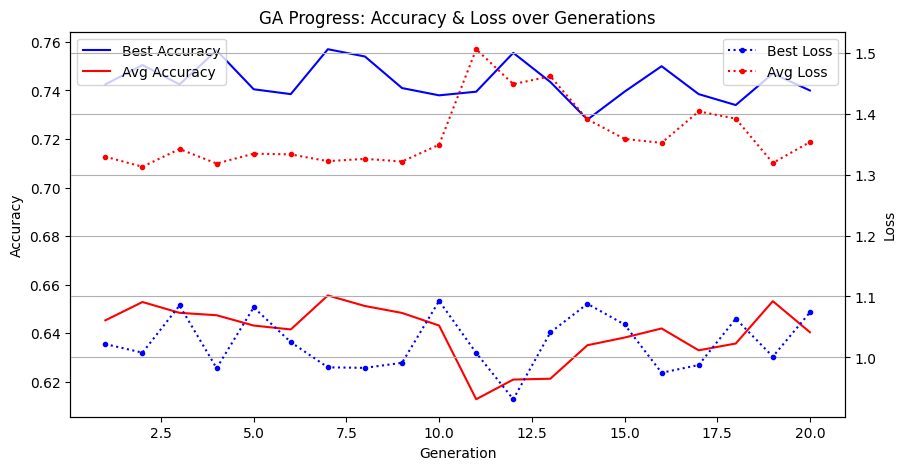

In [29]:
# Step 7: Visualize Evolutionary Progress
# Plot accuracy and loss together
fig, ax1 = plt.subplots(figsize=(10, 5))
gens = list(range(1, GENERATIONS+1))

# Accuracy curves
ax1.plot(gens, best_fitness_history, 'b-',  label='Best Accuracy')
ax1.plot(gens, avg_fitness_history,  'r-', label='Avg Accuracy')
ax1.set_xlabel('Generation')
ax1.set_ylabel('Accuracy')
ax1.legend(loc='upper left')

# Loss curves on secondary axis
ax2 = ax1.twinx()
ax2.plot(gens, best_loss_history, 'b:.', label='Best Loss')
ax2.plot(gens, avg_loss_history,  'r:.',  label='Avg Loss')
ax2.set_ylabel('Loss')
ax2.legend(loc='upper right')
plt.title('GA Progress: Accuracy & Loss over Generations')
plt.grid(True)
plt.show()

In [49]:
# GA Candidates sheet df
df_ga_cand = pd.DataFrame(ga_candidates)

# GA progression sheet df
progress_rows = []
dataset_len = len(test_subset)

for gen, (b_acc, a_acc, b_loss, a_loss, ind) in enumerate(
    zip(best_fitness_history, avg_fitness_history, best_loss_history,
        avg_loss_history, final_pop), start=1):
    progress_rows.append({
        "Generation":           gen,
        "Best Accuracy":        b_acc,
        "Avg Accuracy":         a_acc,
        "Best Loss":            round(b_loss, 6),
        "Avg Loss":             round(a_loss, 6),
        "Peak Train Mem (MB)":  round(ind.peak_train_mb, 6),
        "Train Time (s)":       round(ind.train_time_sec, 6),
        "Peak Inf Mem (MB)":    round(ind.peak_inf_mb, 6),
        "Inf Time (s)":         round(ind.inf_time_sec, 6),
        "Inf per Image (s)":    round(ind.inf_time_sec / dataset_len, 6)
    })
# Convert to DataFrame
df_progress = pd.DataFrame(progress_rows)

# Write new sheets to the same Excel file
with pd.ExcelWriter("all_experiments.xlsx", engine="openpyxl", mode="a") as writer:
    df_ga_cand.to_excel(writer,  sheet_name="All GA Candidates",  index=False)
    df_progress.to_excel(writer, sheet_name="GA Progression", index=False)

In [31]:
# Full training with best hyperparameters
print("\nFinal Training with Best Hyperparameters...")
final_model = ViTForImageClassification.from_pretrained("WinKawaks/vit-tiny-patch16-224")
final_model.classifier = torch.nn.Linear(final_model.config.hidden_size, 100)
torch.nn.init.xavier_uniform_(final_model.classifier.weight)
final_model.to(device)

# Apply best hyperparameters
final_model.config.hidden_dropout_prob = best_ind['dropout']
final_model.config.attention_probs_dropout_prob = best_ind['dropout']
final_model.to(device)

# Configure optimizer
optimizer = AdamW(
    final_model.parameters(),
    lr=best_ind['lr'],
    weight_decay=best_ind['weight_decay']
)
final_model.to(device)


Final Training with Best Hyperparameters...


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=192, out_features=192, bias=True)
              (key): Linear(in_features=192, out_features=192, bias=True)
              (value): Linear(in_features=192, out_features=192, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=192, out_features=192, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=192, out_features=768, bias=True)
            (intermedi

In [32]:
criterion = torch.nn.CrossEntropyLoss()
print(f"\nFinal Training with Best Hyperparameters ({epochs} Epochs on Training Set):")
for epoch in range(epochs):
    final_model.train()
    epoch_losses = []
    epoch_preds  = []
    epoch_labels = []

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        logits = final_model(images).logits
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()

        # record batch metrics
        epoch_losses.append(loss.item())
        preds = logits.argmax(dim=-1).detach().cpu().numpy()
        epoch_preds.extend(preds)
        epoch_labels.extend(labels.cpu().numpy())

    # compute epoch metrics
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    epoch_acc = accuracy_score(epoch_labels, epoch_preds)
    epoch_f1 = f1_score(epoch_labels, epoch_preds, average='macro')
    print(f"Epoch {(epoch+1):2d}/{epochs} — Accuracy: {epoch_acc:.4f}, F1-Score: {epoch_f1:.4f}, Loss: {avg_epoch_loss:.4f}")


Final Training with Best Hyperparameters (5 Epochs on Training Set):
Epoch  1/5 — Accuracy: 0.4124, F1-Score: 0.4130, Loss: 2.4001
Epoch  2/5 — Accuracy: 0.7299, F1-Score: 0.7294, Loss: 0.9145
Epoch  3/5 — Accuracy: 0.8132, F1-Score: 0.8131, Loss: 0.6066
Epoch  4/5 — Accuracy: 0.8651, F1-Score: 0.8647, Loss: 0.4204
Epoch  5/5 — Accuracy: 0.8897, F1-Score: 0.8894, Loss: 0.3356


In [65]:
# Inference evaluation on final, GA‐driven model,
print(f"Final Model Performance:\n{'='*24}")
eval_final = evaluate_model(final_model, test_loader, test_dataset)
print_metrics(eval_final)

Final Model Performance:
Accuracy Score: 0.721500 (72.15%)
F1-Score: 0.711450 (71.14%)
Top-2 Accuracy: 84.65%
Top-5 Accuracy: 93.90%
Log Loss: 1.102825


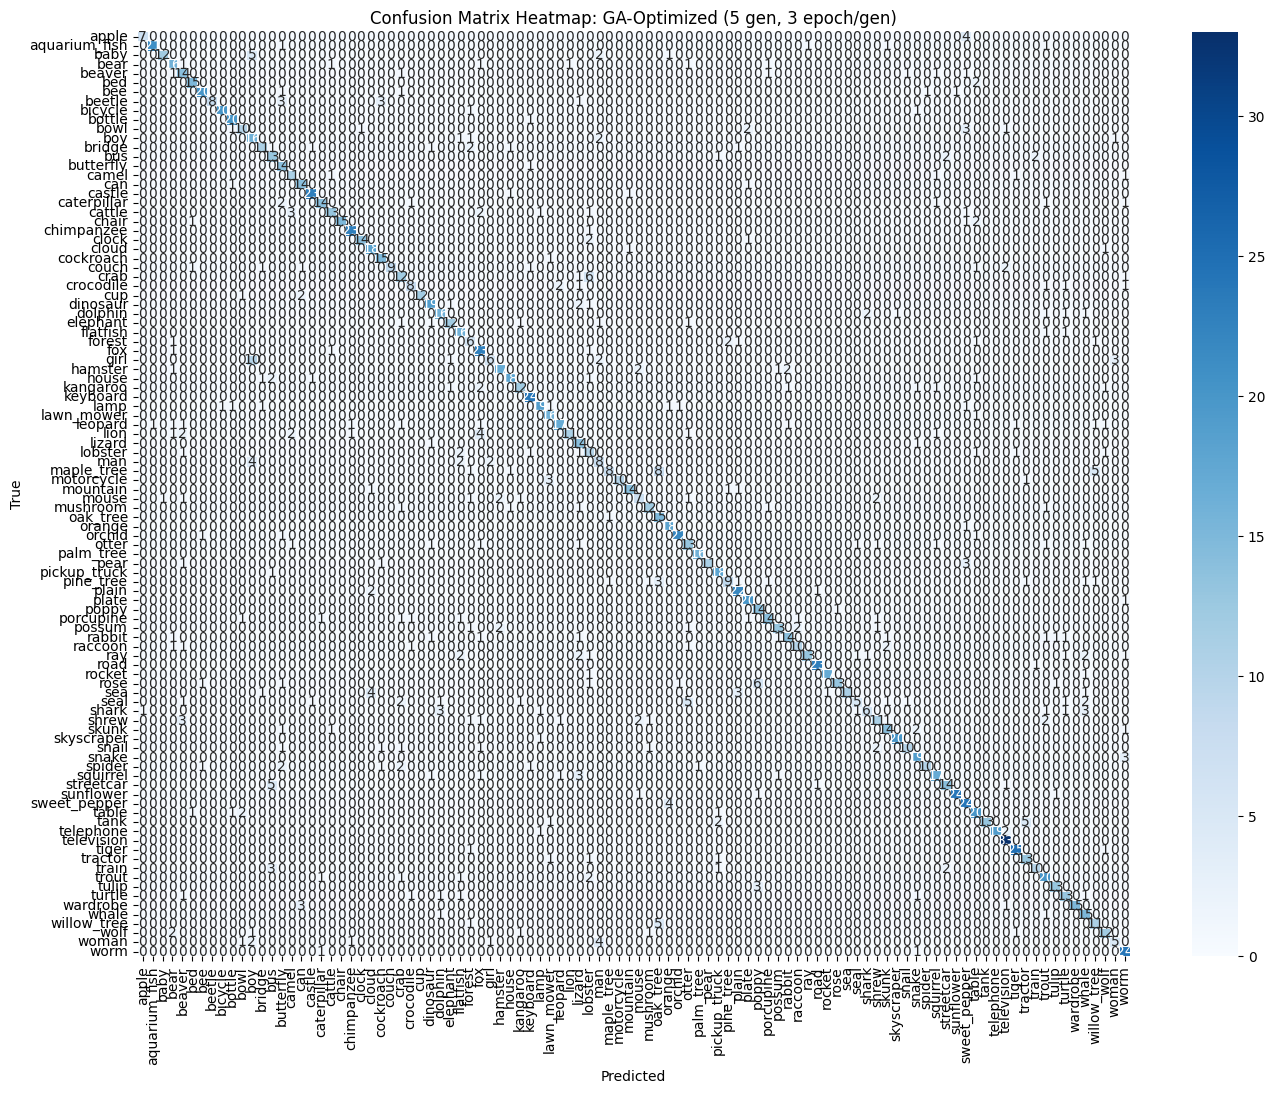

In [42]:
plot_confusion_matrix(eval_final["all_labels"], eval_final["all_preds"], eval_final["classes"], "Confusion Matrix Heatmap: GA-Optimized (5 gen, 3 epoch/gen)")

In [43]:
# Save the finetuned model to disk
output_dir = "best_ga_vit_model"
final_model.save_pretrained(output_dir)
print(f"Saved best GA model to ./{output_dir}")

Saved best GA model to ./best_ga_vit_model


In [40]:
# Zip and download the csv and model to local machine
try:
  # Make zip
  shutil.make_archive('final_results', 'zip', root_dir='.', base_dir='best_ga_vit_model')
  # Add csv into the same zip:
  with ZipFile('final_results.zip', 'a') as z:
      z.write('all_experiments.xlsx')
  # Download zip
  files.download('final_results.zip')
  print("Downloaded model and csv as final_results.zip")
except Exception as e:
    print("Failed to load model from disk:", e)
    raise

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloaded model and csv as final_results.zip


In [45]:
# Load model from disk
try:
     # Load the config and override num_labels
    config = ViTConfig.from_pretrained("./best_ga_vit_model")
    config.num_labels = 100

    # Load the model using that config
    loaded = ViTForImageClassification.from_pretrained(
        output_dir,
        config=config,
    )
    loaded.to(device).eval()
    print("Successfully loaded the model from disk")
except Exception as e:
    print("Failed to load model from disk:", e)
    raise

Successfully loaded the model from disk


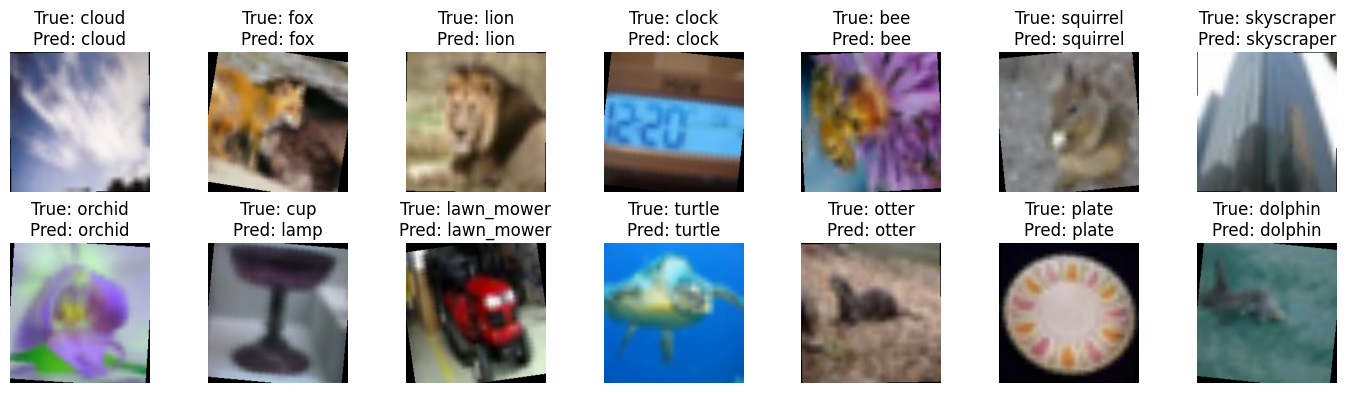

In [46]:
# Number of examples and grid shape
rows, cols = 2, 7
n_show = rows * cols

# Pick random indices
indices = random.sample(range(len(test_dataset)), n_show)

# Create 2×3 subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
# fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
axes = axes.flatten()

for ax, idx in zip(axes, indices):
    img, true_label = test_dataset[idx]
    inp = img.unsqueeze(0).to(device)
    with torch.no_grad():
        logits = loaded(inp).logits
        pred   = logits.argmax(dim=1).item()

    # If normalized in preprocessing, un-normalize here:
    mean = torch.tensor([0.5,0.5,0.5]).reshape(1,1,3)
    std  = torch.tensor([0.5,0.5,0.5]).reshape(1,1,3)
    image = std * img.permute(1,2,0) + mean
    image = torch.clip(image, 0, 1).cpu().numpy()

    # Otherwise just permute CHW→HWC and plot:
    # image = img.permute(1, 2, 0).cpu().numpy()

    ax.imshow(image)
    ax.set_title(f"True: {test_dataset.classes[true_label]}\nPred: {test_dataset.classes[pred]}")
    ax.axis("off")

plt.tight_layout()
plt.show()